In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold
from sklearn import metrics
import xgboost as xgb
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MatrixFactorization, MICE
from sklearn import preprocessing
import operator

In [293]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train = train[train['Park_ID'] != 19]

In [292]:
train.head()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park,Location_Type,Footfall
0,3311712,12,01-09-1990,5.0,37.24,60.8,15.2,92.1300,8225.0,8259.0,8211.0,92.0,304.0,255.0,288.0,222.0,3,1406
1,3311812,12,02-09-1990,7.0,32.68,60.8,7.6,14.1100,8232.0,8280.0,8205.0,172.0,332.0,252.0,297.0,204.0,3,1409
2,3311912,12,03-09-1990,8.0,43.32,60.8,15.2,35.6900,8321.0,8355.0,8283.0,236.0,292.0,219.0,279.0,165.0,3,1386
3,3312012,12,04-09-1990,8.0,25.84,38.0,7.6,0.0249,8379.0,8396.0,8358.0,272.0,324.0,225.0,261.0,192.0,3,1365
4,3312112,12,05-09-1990,5.0,28.88,45.6,7.6,0.8300,8372.0,8393.0,8335.0,236.0,332.0,234.0,273.0,183.0,3,1413


In [299]:
def transform_data(data):
    data.loc[data['Var1']>=300,'Var1'] = data[data['Var1']>=300]['Var1'].median()
    data['Date'] = pd.to_datetime(data['Date'])
    data['Month'] = data['Date'].dt.month
    # data['Year'] = data['Date'].dt.year
    data['Day'] = data['Date'].dt.day
    data['Is6789Day'] = pd.to_numeric(data['Date'].dt.day.isin([6,7,8,9])) # thoda kharaab
    data['Is78Month'] = pd.to_numeric(data['Date'].dt.month.isin([7,8]))  # thoda kharaab
    data['Season'] =  data['Date'].dt.month.apply( lambda x: 1 if (x<=4) else 2 if (x>4 and x<=8 ) else 3)
    data['WeekOfYear'] = data['Date'].dt.weekofyear
    # data['DayOfYear'] = data['Date'].dt.dayofyear 
    data['WeekDay'] = data['Date'].dt.weekday
    data['IsWed'] = pd.to_numeric(data['WeekDay'] == 2)
    data['IsFri'] = pd.to_numeric(data['WeekDay'] == 4) 
    # data['IsLeap'] = pd.to_numeric(data['Date'].dt.year %4 == 0) # isse kharaaab
    # Average Ambient Pollution bhi nikal lo
    data['Diff_Breeze_Speed'] = data['Max_Breeze_Speed'] - data['Min_Breeze_Speed']
    data['Diff_Atmospheric_Pressure'] = data['Max_Atmospheric_Pressure'] - data['Min_Atmospheric_Pressure']
    data['Diff_Ambient_Pollution'] = data['Max_Ambient_Pollution'] - data['Min_Ambient_Pollution']
    # data['Average_Ambient_Pollution'] = (data['Max_Ambient_Pollution'] + data['Min_Ambient_Pollution'])/2
    data['Diff_Moisture_In_Park'] = data['Max_Moisture_In_Park'] - data['Min_Moisture_In_Park']
    # data['Breeze_Speed'] = data['Diff_Breeze_Speed'] / data['Average_Breeze_Speed']
    # data['Atm_Pressure'] = data['Diff_Atmospheric_Pressure'] / data['Average_Atmospheric_Pressure']
    # data['Amb_Pollution'] = data['Diff_Ambient_Pollution'] / data['Average_Ambient_Pollution']
    # data['Moisture_In_Park'] = data['Diff_Moisture_In_Park'] / data['Average_Moisture_In_Park']
    # data = data.drop(labels=['Date'], axis=1)
    # ,'Max_Ambient_Pollution','Max_Atmospheric_Pressure','Max_Breeze_Speed' ,'Max_Moisture_In_Park', 'Min_Moisture_In_Park','Min_Ambient_Pollution', 'Min_Atmospheric_Pressure', 'Min_Breeze_Speed'
    data = data.drop(labels=['Date'], axis=1)
    # data = data.drop(labels=['Diff_Breeze_Speed', 'Diff_Atmospheric_Pressure', 'Diff_Ambient_Pollution', 'Diff_Moisture_In_Park', 'Average_Moisture_In_Park', 'Average_Ambient_Pollution', 'Average_Atmospheric_Pressure', 'Average_Breeze_Speed'], axis =1)
    # data['Year'] = data['Year'] - data['Year'].min()
    columns = data.columns.values
    # data.loc[data['Direction_Of_Wind'].isnull(), 'Direction_Of_Wind'] = np.round(np.random.uniform(0,360))
    data['Direction_Of_Wind'].fillna(np.round(np.random.uniform(0,360)), inplace=True)
    data['Direction_Of_Wind'] = pd.cut(data['Direction_Of_Wind'], 10, labels=False)
    # data = MICE().complete(data)
    
    for col in columns:
        # fill missing data with median values # GENERIC WAY
        #data.loc[data[col].isnull(), col] = data[col].median()
        # random sampling
        # data.loc[data[col].isnull(), col] = data.loc[data[col].notnull(), col].sample( n = 1 )
        # data[col].fillna(np.random.choice(data.loc[data[col].notnull(), col]), inplace=True)
        data[col].fillna(data[col].median(), inplace=True)
        if (col not in['Park_ID', 'Location_Type', 'Season','Month', 'Day', 'WeekDay','WeekOfYear', 'Direction_Of_Wind', 'Is6789Day', 'Is78Month']):
            data[col] = MinMaxScaler().fit_transform(data[col].reshape(-1,1))
    
    encoder  = preprocessing.LabelEncoder()
#     data['Park_ID'] = encoder.fit_transform(data['Park_ID'].reshape(-1,1))
    data['Location_Type'] =encoder.fit_transform(data['Location_Type'].reshape(-1,1))
    dummy_columns = ['Park_ID','Location_Type', 'Direction_Of_Wind', 'Season','Month', 'Day', 'WeekDay','WeekOfYear' ]
#     # data = data.drop(labels=['Park_ID', 'Location_Type'], axis = 1)
    data = pd.get_dummies(data, columns= dummy_columns)
    
    return data;

In [300]:
df = train
df= df.drop(labels='Footfall', axis=1)
df= df.append(test, ignore_index=True)
df = df.drop('ID', axis=1)

print (train.shape, test.shape, df.shape)
df = transform_data(df)

print (train.shape, test.shape, df.shape)
df_train_data = df.ix[0:train.shape[0]-1,]
df_train_labels = train['Footfall']
df_test_data = df.ix[train.shape[0]:df.shape[0],]
target = 'Footfall'
print (df_train_data.shape, df_test_data.shape, df_train_labels.shape)

((111538, 18), (39420, 17), (150958, 16))


/home/arjun/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype bool was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arjun/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype bool was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arjun/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((111538, 18), (39420, 17), (150958, 167))
((111538, 167), (39420, 167), (111538,))


In [296]:
df_train_data.head()

,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,...,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52,WeekOfYear_53
0,0.226131,0.250000,0.117647,0.256351,0.400990,0.425210,0.471366,0.255814,0.850575,0.785714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.195980,0.250000,0.058824,0.039261,0.412541,0.460504,0.462555,0.488372,0.931034,0.771429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.266332,0.250000,0.117647,0.099307,0.559406,0.586555,0.577093,0.674419,0.816092,0.614286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.150754,0.142857,0.058824,0.000069,0.655116,0.655462,0.687225,0.779070,0.908046,0.642857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.170854,0.178571,0.058824,0.002309,0.643564,0.650420,0.653451,0.674419,0.931034,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
def apply_grid_search(regressor_algo, parameters, data, labels):
    result_rmse = []
    result_score = []
    train_data, tr_test_data, train_labels, tr_test_labels = train_test_split( data, labels, test_size=0.33, random_state=42)
    reg = regressor_algo
    grid_search = GridSearchCV(reg, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("parameters:")
    print(parameters)
    grid_search.fit(train_data, train_labels)
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    best_est= grid_search.best_estimator_    
    predicted_labels = best_est.predict(tr_test_data)
    error = np.sqrt(metrics.mean_squared_error(tr_test_labels,predicted_labels))
    result_rmse.append(error)
    result_score.append(best_est.score(tr_test_data, tr_test_labels))

    return ( result_rmse, result_score, best_est )

In [ ]:
param_grid_ = {'max_depth': [3, 5, 7, 10],
              'n_estimators' : [100, 250, 500],
               'learning_rate' : [0.1, 0.05, 0.01]
             }
gridSearch_rmse_, gridSearch_score_, bestEstimator_ = apply_grid_search(xgb.XGBRegressor(), \
                                                                        param_grid_, df_train_data, df_train_labels)


In [44]:
data = df_train_data
labels = df_train_labels
params = bestEstimator_.get_params()
result_rmse = []
cv = KFold(len(data), n_folds=10, shuffle=False, random_state=None)
#gb1 = GradientBoostingRegressor( n_estimators = 200, max_depth = 10, learning_rate = 0.01) #BestTillNow 
gb1 = xgb.XGBRegressor(**params)
for trainindex, testindex in cv:
    randomindexs = np.random.permutation(len(data))
    data = data.iloc[randomindexs]
    labels = labels.iloc[randomindexs]
    train_data = data.iloc[trainindex]
    train_labels = labels.iloc[trainindex]
    tr_test_data = data.iloc[testindex]
    tr_test_labels = labels.iloc[testindex]

    gb1.fit(train_data, train_labels)
    predicted_labels = gb1.predict(tr_test_data)
    rmse= np.sqrt(metrics.mean_squared_error(tr_test_labels, predicted_labels))
    result_rmse.append(rmse)

print (result_rmse)
print ('mean rmse: ', np.mean(result_rmse))


[64.092687604766667, 62.878507951790738, 63.764818315551786, 64.251997468273885, 63.890284912411943, 63.287420306233876, 63.647491807569864, 63.088171384144125, 63.57911871906105, 63.507937126907578]
('mean rmse: ', 63.598843559671153)


In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split( df_train_data, df_train_labels, test_size=0.25, random_state=42) 
gb1 = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators = 500)
#gb1 = GradientBoostingRegressor( n_estimators = 500, max_depth = 10, learning_rate = 0.01)
gb1.fit(X_train, y_train)
predicted_labels = gb1.predict(X_test)
rmse= np.sqrt(metrics.mean_squared_error(y_test, predicted_labels))
print rmse

In [210]:
xgb_params = {
    "objective": "reg:linear", 
    "min_child_weight" : 15,  
    "eta": 0.01, 
    "max_depth": 10, 
    "seed": 42, 
    "silent": 0,
    "early_stopping_rounds" : 15
}
num_rounds = 1000


dtrain = xgb.DMatrix(df_train_data, label=df_train_labels)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

In [301]:
df_train_data.columns.values


array(['Average_Breeze_Speed', 'Max_Breeze_Speed', 'Min_Breeze_Speed',
       'Var1', 'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure',
       'Min_Atmospheric_Pressure', 'Min_Ambient_Pollution',
       'Max_Ambient_Pollution', 'Average_Moisture_In_Park',
       'Max_Moisture_In_Park', 'Min_Moisture_In_Park', 'Is6789Day',
       'Is78Month', 'IsWed', 'IsFri', 'Diff_Breeze_Speed',
       'Diff_Atmospheric_Pressure', 'Diff_Ambient_Pollution',
       'Diff_Moisture_In_Park', 'Park_ID_12', 'Park_ID_13', 'Park_ID_14',
       'Park_ID_15', 'Park_ID_16', 'Park_ID_17', 'Park_ID_18',
       'Park_ID_20', 'Park_ID_21', 'Park_ID_22', 'Park_ID_23',
       'Park_ID_24', 'Park_ID_25', 'Park_ID_26', 'Park_ID_27',
       'Park_ID_28', 'Park_ID_29', 'Park_ID_30', 'Park_ID_31',
       'Park_ID_32', 'Park_ID_33', 'Park_ID_34', 'Park_ID_35',
       'Park_ID_36', 'Park_ID_37', 'Park_ID_38', 'Park_ID_39',
       'Location_Type_0', 'Location_Type_1', 'Location_Type_2',
       'Location_Type_3', 'Di

In [302]:
# cross validation
xgb_params = {
    "objective": "reg:linear", 
    "min_child_weight" : 10,  
    "eta": 0.05, 
    "max_depth": 10, 
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    "seed": 42, 
    "silent": 1,
    "early_stopping_rounds" : 20
}
num_rounds = 1000

dtrain = xgb.DMatrix(df_train_data, label=df_train_labels)

print ('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
gbdt_cv = xgb.cv(xgb_params, dtrain, num_rounds, nfold=5,
    metrics={'rmse'}, seed = 0, verbose_eval=False, show_stdv=False )
best_nrounds = gbdt_cv.shape[0] -1
print ('running training')
gbdt = xgb.train(xgb_params, dtrain, best_nrounds)

running cross validation
running training


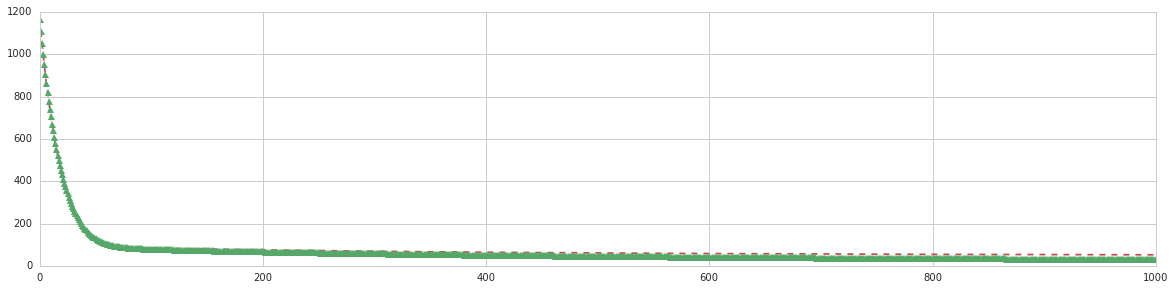

In [303]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(np.arange(gbdt_cv.shape[0]), gbdt_cv['test-rmse-mean'], 'r--', np.arange(gbdt_cv.shape[0]), gbdt_cv['train-rmse-mean'], 'g^')

In [304]:
gbdt_cv

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,1168.035083,1.153195,1168.038135,0.277725
1,1110.420068,1.055820,1110.419165,0.315531
2,1055.773657,1.066940,1055.770728,0.289743
3,1003.956518,1.115559,1003.934241,0.286067
4,954.707641,1.150198,954.716003,0.320921
5,907.921240,1.066171,907.926184,0.340774
6,863.426001,0.991727,863.428015,0.377335
7,821.273828,1.000621,821.266150,0.420279
8,781.131702,0.932884,781.124902,0.398015
9,743.150684,0.928604,743.126196,0.407418


In [211]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()


In [251]:
df_train_data.columns.values

array(['Park_ID', 'Direction_Of_Wind', 'Average_Breeze_Speed',
       'Max_Breeze_Speed', 'Min_Breeze_Speed', 'Var1',
       'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure',
       'Min_Atmospheric_Pressure', 'Min_Ambient_Pollution',
       'Max_Ambient_Pollution', 'Average_Moisture_In_Park',
       'Max_Moisture_In_Park', 'Min_Moisture_In_Park', 'Month', 'Day',
       'Season', 'WeekOfYear', 'WeekDay', 'IsWed', 'IsFri',
       'Diff_Breeze_Speed', 'Diff_Atmospheric_Pressure',
       'Diff_Ambient_Pollution', 'Diff_Moisture_In_Park',
       'Location_Type_0', 'Location_Type_1', 'Location_Type_2',
       'Location_Type_3'], dtype=object)

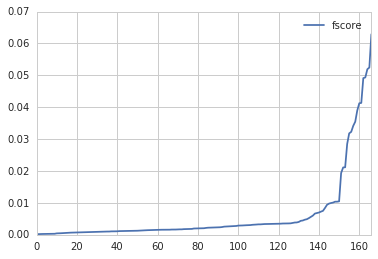

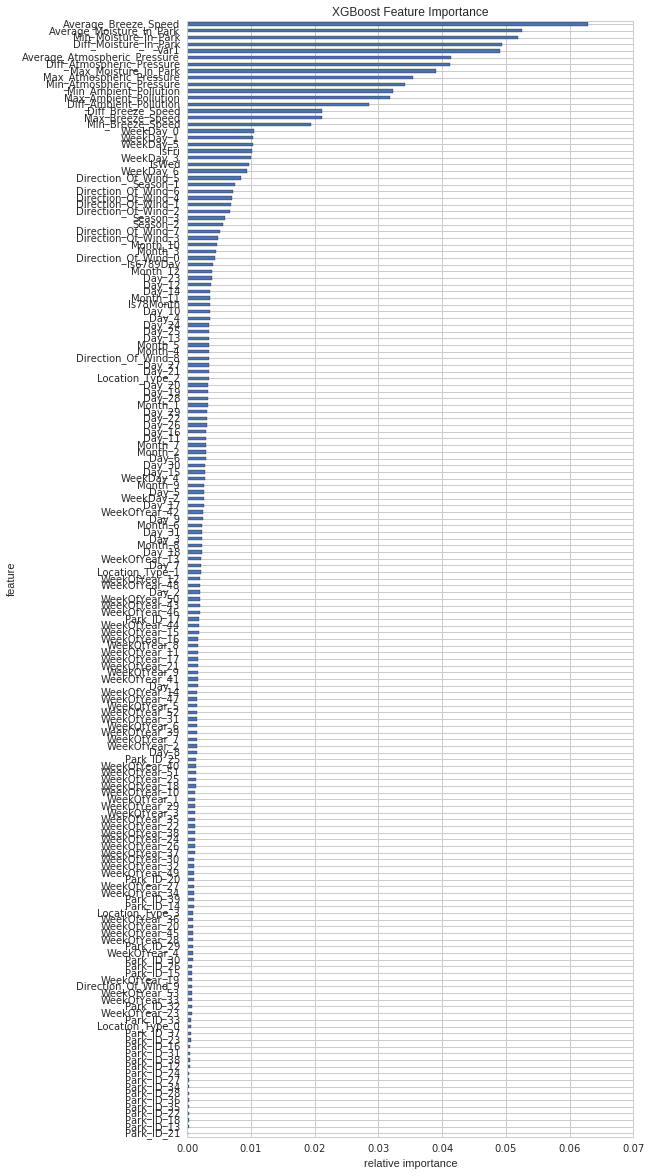

In [305]:
ceate_feature_map(df_train_data.columns.values)
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(8, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')


In [23]:
predictions = pd.DataFrame(gb1.predict(df_test_data))
results = pd.DataFrame();
results['ID'] = test['ID']
results['Footfall'] = np.round(predictions)
timestr = time.strftime("%Y%m%d-%H%M%S")
results.to_csv('submission' + timestr + ".csv", index=False)

In [306]:
predictions = pd.DataFrame(gbdt.predict(xgb.DMatrix(df_test_data)))
results = pd.DataFrame();
results['ID'] = test['ID']
results['Footfall'] = np.round(predictions)
timestr = time.strftime("%Y%m%d-%H%M%S")
results.to_csv('submission' + timestr + ".csv", index=False)